# setup

In [28]:
# magic
%matplotlib inline

In [19]:
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
import os

# set matplotlib size
def mpl_figsize(scale_factor: int | float) -> tuple[float, float]:
    return 6.4 * scale_factor, 4.8 * scale_factor

def mpl_figsize_xy(scale_factor_x: int | float, scale_factor_y: int | float) -> tuple[float, float]:
    return 6.4 * scale_factor_x, 4.8 * scale_factor_y


In [20]:
# setup connection
conn = psycopg2.connect(
    host='localhost',
    database='cadets_e3',
    user='rosendahl',
    # passfile='~/.pgpass',
)
# get cursor
cur = conn.cursor()

In [34]:
# debug
os.system("hostnamectl hostname")
print(f'current working directory: {os.getcwd()}')

odin
current working directory: /home/rosendahl/Cloud/hs/bachelor_thesis/trustdatastoredb


# collection of useful queries/values from the data

In [11]:
query = '''
select count(*)
from event;
'''
cur.execute(query)
no_events = cur.fetchall()[0][0]
print(f'number of events: {no_events}')


query = '''
select count(*)
from subject;
'''
cur.execute(query)
no_subjects = cur.fetchall()[0][0]
print(f'number of subjects: {no_subjects}')


query = '''
select count(*)
from principal;
'''
cur.execute(query)
no_principals = cur.fetchall()[0][0]
print(f'number of principals: {no_principals}')


number of events: 41350895
number of subjects: 224629
number of principals: 63


We probably want to predict _properties_map_exec_, what possible categories/classes are there?

In [12]:
query = '''
select distinct e.properties_map_exec, count(e.properties_map_exec) as count 
from event e 
group by e.properties_map_exec;
'''

cur.execute(query)
results_count_distinct_execs = cur.fetchall()


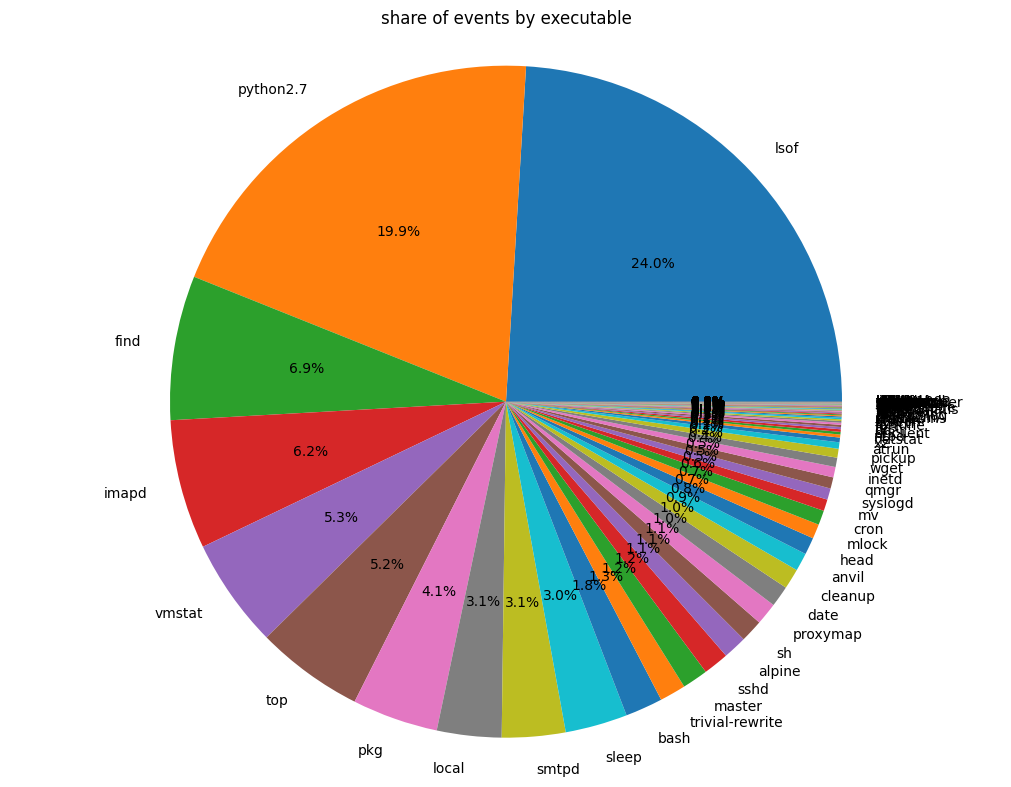

In [31]:
# plot exec distribution

# sort by count
results_count_distinct_execs.sort(key=lambda x: x[1], reverse=True)

labels = [row[0] for row in results_count_distinct_execs]
sizes = [row[1] for row in results_count_distinct_execs]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# resize
fig.set_size_inches(mpl_figsize(2))
plt.title('share of events by executable')
plt.show()

note that 'NULL' is also a possible value, should probably be discarded

this is not the real class distribution, as it does not take sequence length into account  
over/under representation of certain classes might be due to longer/shorter sequences


# filter out subjects with NULL execs
since NULL is a possible value, we should check how many events have a NULL value for _properties_map_exec_  
these events should be discarded for the classification task if there is no way to impute the value TODO: check docs

In [20]:
query = '''
select distinct s.uuid
from event e
join subject s
    on e.subject_uuid = s.uuid
where e.properties_map_exec is null;
'''

cur.execute(query)
result_exec_null_subject_uuids = cur.fetchall()

# convert tuples to list
result_exec_null_subject_uuids = [row[0] for row in result_exec_null_subject_uuids]


print(f'number of events with NULL exec: {len(result_exec_null_subject_uuids)}')
print(f'share of events with NULL exec: {len(result_exec_null_subject_uuids)*100 / no_events :.5f}%')


number of events with NULL exec: 313
share of events with NULL exec: 0.00151%


the share of NULL execs is quite low, so we can probably discard these events

# filter out subjects with duplicate execs
until now, we assumed that subjects do not have duplicate execs (eg. first some sh events, then something different, then sh again)  
minimum sequence len of 1 and other things make me doubt this assumption

In [22]:
# find all sequences

query = """
select s.uuid, e.uuid, e.properties_map_exec
from event e
join subject s
    on e.subject_uuid = s.uuid
order by s.uuid, e.sequence_long;
"""

cur.execute(query)

# find all subject.uuids's + event.uuid's where the same exec occurs multiple times with interruptions in between
dup_execs_uuids = []

last_s_uuid = None
last_exec = None
subject_prev_execs = []

for row in cur:
    current_s_uuid, current_e_uuid, current_exec = row
    
    # if new subject, update last subject
    if current_s_uuid != last_s_uuid:
        last_s_uuid = current_s_uuid
        subject_prev_execs.clear()
        last_exec = None
    
    if current_exec != last_exec:
        if current_exec in subject_prev_execs:
            print(f'duplicate exec: {current_exec} for subject {current_s_uuid}')
            print(f'previous execs: {subject_prev_execs}')
            dup_execs_uuids.append((current_s_uuid, current_e_uuid, current_exec))
        subject_prev_execs.append(current_exec)
        last_exec = current_exec


duplicate exec: sendmail for subject 03B5B9F9-3DF4-11E8-A5CB-3FA3753A265A
previous execs: ['sendmail', None]
duplicate exec: None for subject 03B5B9F9-3DF4-11E8-A5CB-3FA3753A265A
previous execs: ['sendmail', None, 'sendmail']
duplicate exec: sendmail for subject 03B5B9F9-3DF4-11E8-A5CB-3FA3753A265A
previous execs: ['sendmail', None, 'sendmail', None]
duplicate exec: sendmail for subject 06C87090-3F1B-11E8-A5CB-3FA3753A265A
previous execs: ['sendmail', None]
duplicate exec: None for subject 06C87090-3F1B-11E8-A5CB-3FA3753A265A
previous execs: ['sendmail', None, 'sendmail']
duplicate exec: sendmail for subject 06C87090-3F1B-11E8-A5CB-3FA3753A265A
previous execs: ['sendmail', None, 'sendmail', None]
duplicate exec: sendmail for subject 08A1738D-3DC8-11E8-A5CB-3FA3753A265A
previous execs: ['sendmail', None]
duplicate exec: None for subject 08A1738D-3DC8-11E8-A5CB-3FA3753A265A
previous execs: ['sendmail', None, 'sendmail']
duplicate exec: sendmail for subject 08A1738D-3DC8-11E8-A5CB-3FA3753

In [23]:
# ensure that there are no duplicates in result
dup_execs_uuids = list(set(dup_execs_uuids))
print(f'found {len(dup_execs_uuids)} subjects with duplicate execs')

# find out what execs are the duplicate ones and how often they occur
dup_execs = {}
for s_uuid, e_uuid, exec in dup_execs_uuids:
    if exec in dup_execs:
        dup_execs[exec] += 1
    else:
        dup_execs[exec] = 1
        
# sort by count
dup_execs = {k: v for k, v in sorted(dup_execs.items(), key=lambda item: item[1], reverse=True)}
print(dup_execs)

found 664 subjects with duplicate execs
{'cp': 209, None: 172, 'tee': 120, 'sendmail': 116, 'pw': 24, 'ping': 10, 'sh': 7, 'mail.local': 6}


In [24]:
subject_blacklist = set()

# add NULLs 
subject_blacklist.update(result_exec_null_subject_uuids)

# add subjects with duplicate execs
subject_blacklist.update([s_uuid for s_uuid, _, _ in dup_execs_uuids])

print(f'blacklisted subjects: {len(subject_blacklist)}')
print(f'blacklisted subjects share: {len(subject_blacklist)*100 / no_subjects:.5f}%')

no_valid_subjects = no_subjects - len(subject_blacklist)
print(f'number of valid_subjects: {no_valid_subjects}')

blacklisted subjects: 320
blacklisted subjects share: 0.27288%
number of valid_subjects: 116947


# subjects are now filtered, get info about the class distribution again

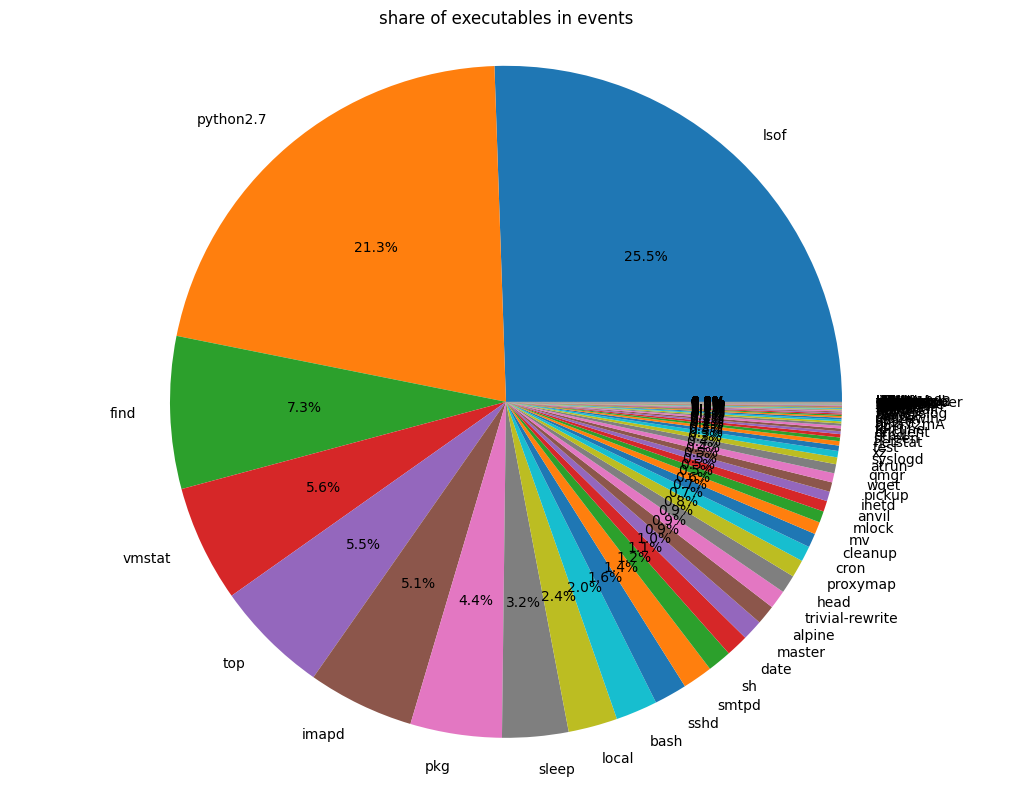

In [25]:
query = '''
select distinct e.properties_map_exec, count(e.properties_map_exec) as count
from event e
join subject s
    on e.subject_uuid = s.uuid
where s.uuid not in %s
group by e.properties_map_exec;
'''

cur.execute(query, (tuple(subject_blacklist),))
results_count_distinct_execs_no_null = cur.fetchall()

# plot exec distribution

# sort by count
results_count_distinct_execs_no_null.sort(key=lambda x: x[1], reverse=True)

labels = [row[0] for row in results_count_distinct_execs_no_null]
sizes = [row[1] for row in results_count_distinct_execs_no_null]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# resize
fig.set_size_inches(mpl_figsize(2))
plt.title('share of executables in events')
plt.show()

this plot does not take sequence size into account  
when ignoring sequence length, how do these proportions change?  
in other words: what are the shares of different events, disregarding sequence length  
this should also be the class distribution 

In [26]:
query = '''
select distinct event_subject.properties_map_exec, count(properties_map_exec) as c
from (select distinct subject.uuid, event.properties_map_exec
from event
join subject
    on event.subject_uuid = subject.uuid
where subject.uuid not in %s
group by subject.uuid, event.properties_map_exec
order by subject.uuid) as event_subject
group by event_subject.properties_map_exec; 
'''

cur.execute(query, (tuple(subject_blacklist),))
classes_occurrence = cur.fetchall()


bash: 85996
sleep: 33016
vmstat: 16483
sh: 12627
top: 8360
date: 8253
lsof: 8246
head: 8242
imapd: 7643
mv: 5838
cron: 5432
sshd: 3772
master: 3251
mlock: 3069
inetd: 1996
atrun: 1664
local: 1012
sysctl: 838
dd: 833
unlink: 827
resizewin: 752
fortune: 751
alpine: 615
smtpd: 546
proxymap: 448
python2.7: 442
trivial-rewrite: 417
cleanup: 402
anvil: 346
netstat: 277
rm: 244
sendmail: 236
cat: 177
find: 151
newsyslog: 145
mkdir: 143
dmesg: 121
wget: 120
uptime: 114
pkg: 93
pickup: 85
adjkerntz: 72
hostname: 71
sudo: 68
dhclient: 58
ls: 56
ps: 53
wc: 51
route: 46
mktemp: 43
grep: 42
awk: 33
cmp: 29
mailwrapper: 25
lockf: 24
egrep: 18
links: 18
sed: 16
mount: 15
less: 14
mail: 14
sort: 14
nginx: 13
kenv: 12
kill: 12
tty: 12
basename: 11
expr: 11
tr: 10
screen: 9
df: 7
bzcat: 6
bzip2: 6
chkgrp: 6
csh: 6
diff: 6
msgs: 6
ping: 6
test: 6
xz: 6
ipfstat: 5
jot: 5
postmap: 5
tail: 5
uname: 5
bounce: 4
cp: 4
env: 4
nohup: 4
pw: 4
smtp: 4
stat: 4
su: 4
vi: 4
ifconfig: 3
ipfw: 3
ipop3d: 3
limits: 3
na

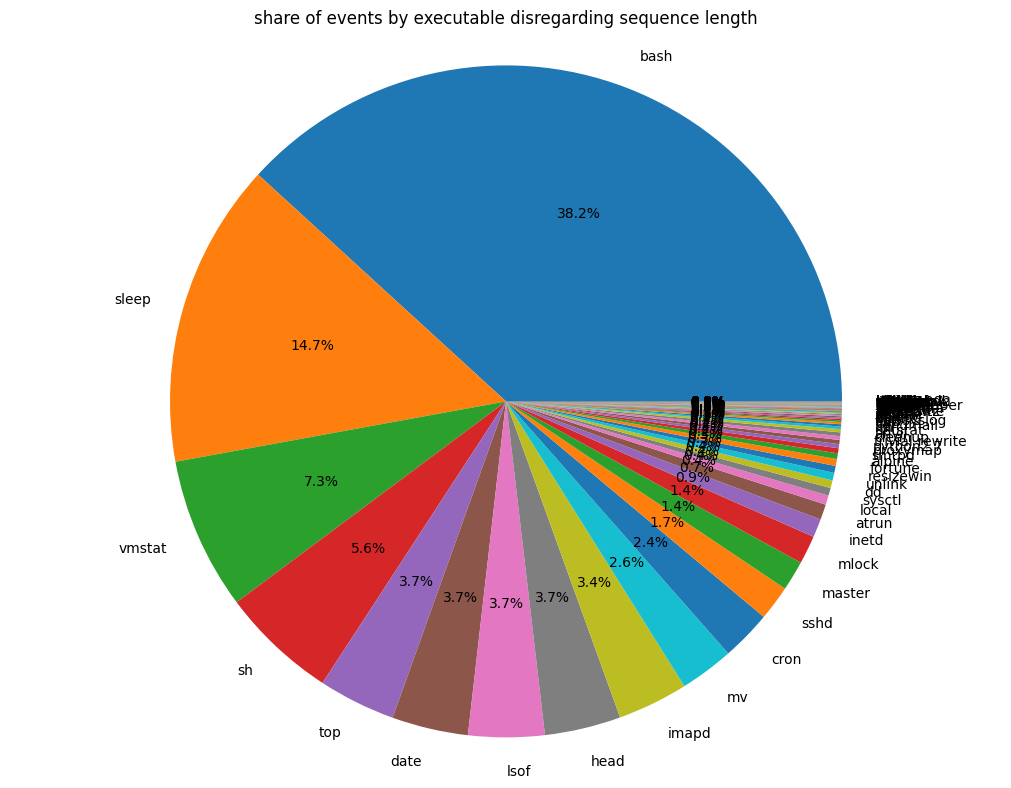

In [27]:
# pie chart plot

# sort by count
classes_occurrence.sort(key=lambda x: x[1], reverse=True)

labels = [row[0] for row in classes_occurrence]
sizes = [row[1] for row in classes_occurrence]

for label, size in zip(labels, sizes):
    print(f'{label}: {size}')

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# resize
fig.set_size_inches(mpl_figsize(2))
plt.title('share of events by executable disregarding sequence length')
plt.show()

# class info

In [28]:
no_classes = len(classes_occurrence)

print(f'number of classes: {no_classes}')
print(f'number of classes with less than 10 sequences: {len([row for row in classes_occurrence if row[1] < 10])}')
print(f'number of classes with less than 100 sequences: {len([row for row in classes_occurrence if row[1] < 100])}')

number of classes: 128
number of classes with less than 10 sequences: 59
number of classes with less than 100 sequences: 89


# sequence info

In [29]:
# find all sequences and their lengths
query = '''
select s.uuid, count(e.uuid) as seq_len, e.properties_map_exec
from event e
join subject s
    on e.subject_uuid = s.uuid
where s.uuid not in %s
group by s.uuid, e.properties_map_exec
order by s.uuid, seq_len;
'''
cur.execute(query, (tuple(subject_blacklist),))
result = cur.fetchall()

In [33]:
# get general sequence info

seq_lens = np.array([row[1] for row in result])
no_sequences = len(seq_lens)

print(f'sequences amount: {no_sequences}')
print(f'min seq len: {np.min(seq_lens)}')
print(f'max seq len: {np.max(seq_lens)}')
print(f'mean seq len: {np.mean(seq_lens)}')
print(f'median seq len: {np.median(seq_lens)}')
print(f'std seq len: {np.std(seq_lens)}')
print(f'var seq len: {np.var(seq_lens)}\n')

# percentage of sequences with length 1
print(f'number of sequences with length <= 10: {len([l for l in seq_lens if l <= 10])}')
print(f'percentage of sequences with length <= 10: {len([l for l in seq_lens if l <= 10])*100 / no_sequences:.5f}%')
print(f'percentage of sequences with length <= 10: {len([l for l in seq_lens if l <= 10])*100 / no_sequences:.5f}%')
print(f'percentage of sequences with length >= 100: {len([l for l in seq_lens if l >= 1000])*100 / no_sequences:.5f}%\n')

# hard filter any sequences with length <= 10
# filtered = np.array([i for i in seq_lens if i > 10])
filtered = np.array(seq_lens)

# find p95 and p5
p = 5
p_l = np.percentile(filtered, p)
p_u = np.percentile(filtered, 100-p)

print(f'percentiles for p{p} and p{100-p} (total: {100-2*p}%): {p_l}, {p_u}\n')

# how many sequences are in range [p_l, p_u]
print(f'number of sequences in range [p_l, p_u]: {len([l for l in filtered if p_l <= l <= p_u])}')
print(f'relative number of sequences in range [p_l, p_u]: {len([l for l in filtered if p_l <= l <= p_u]) / no_sequences:.5f}%\n')

# filter percentiles
filtered = np.array([i for i in filtered if p_l <= i <= p_u])

print(f'sequences amount: {len(filtered)}')
print(f'min seq len: {np.min(filtered)}')
print(f'max seq len: {np.max(filtered)}')
print(f'mean seq len: {np.mean(filtered)}')
print(f'median seq len: {np.median(filtered)}')
print(f'std seq len: {np.std(filtered)}')
print(f'var seq len: {np.var(filtered)}')


sequences amount: 225082
min seq len: 1
max seq len: 2262676
mean seq len: 92.01511893443278
median seq len: 20.0
std seq len: 5585.744567367922
var seq len: 31200542.371880256

number of sequences with length <= 10: 108098
percentage of sequences with length <= 10: 48.02605%
percentage of sequences with length <= 10: 48.02605%
percentage of sequences with length >= 100: 0.39497%

percentiles for p5 and p95 (total: 90%): 1.0, 369.0

number of sequences in range [p_l, p_u]: 213840
relative number of sequences in range [p_l, p_u]: 0.95005%

sequences amount: 213840
min seq len: 1
max seq len: 369
mean seq len: 27.794014216236437
median seq len: 10.0
std seq len: 49.057545533257645
var seq len: 2406.642773747647


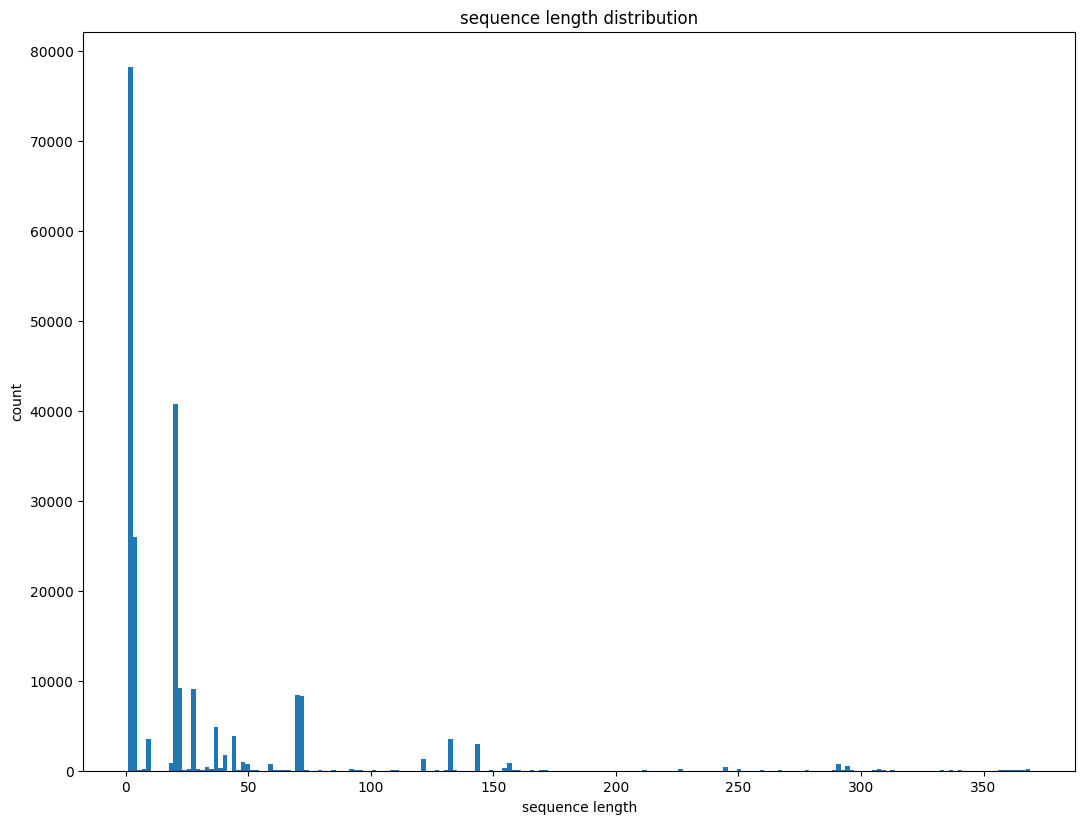

In [34]:
# plot sequence length distribution
fig, ax = plt.subplots()

ax.hist(filtered, bins=200)
ax.set_title('sequence length distribution')
ax.set_xlabel('sequence length')
ax.set_ylabel('count')

# set y log
# ax.set_yscale('log')

# resize
fig.set_size_inches(mpl_figsize(2))
plt.show()

# plot share of execs in sequences

In [35]:
# find share of execs in sequences
query = '''
select event_subject.properties_map_exec, count(properties_map_exec) as c
from (select distinct subject.uuid, event.properties_map_exec
from event
join subject
    on event.subject_uuid = subject.uuid
where subject.uuid not in %s
group by subject.uuid, event.properties_map_exec
order by subject.uuid) as event_subject
group by event_subject.properties_map_exec;
'''

cur.execute(query, (tuple(subject_blacklist),))
execs_in_sequences = cur.fetchall()

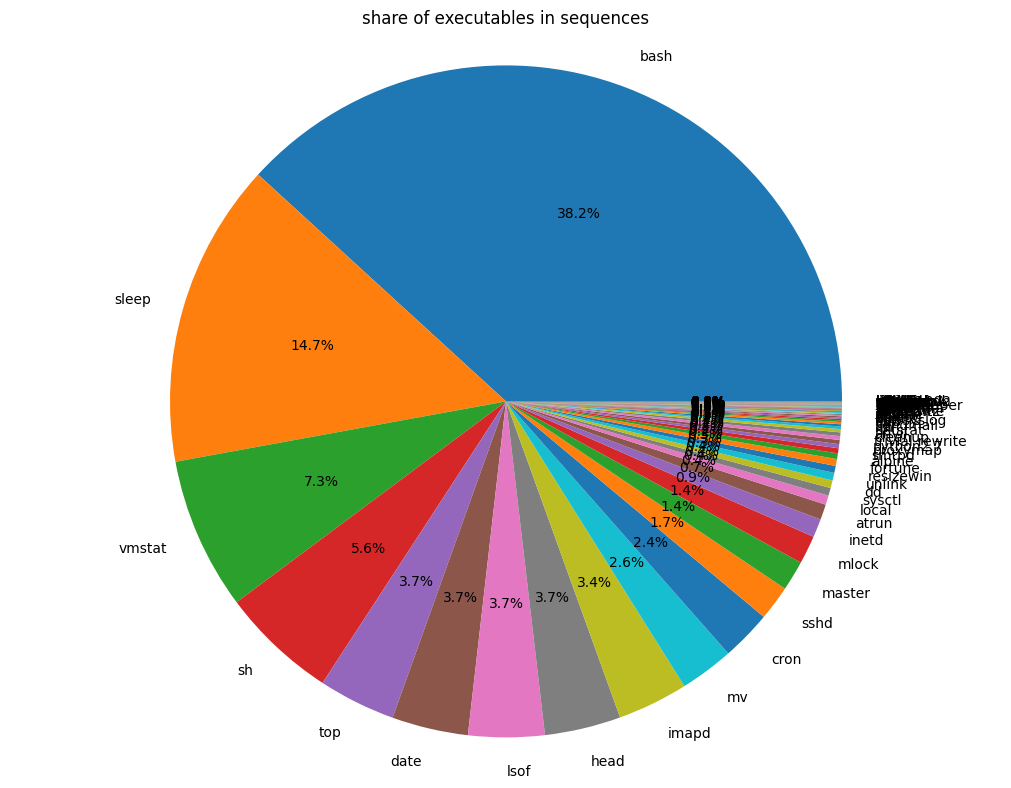

In [36]:
# plot pie chart of share of execs in sequences

# sort by count
execs_in_sequences.sort(key=lambda x: x[1], reverse=True)

labels = [row[0] for row in execs_in_sequences]
sizes = [row[1] for row in execs_in_sequences]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# resize
fig.set_size_inches(mpl_figsize(2))
plt.title('share of executables in sequences')
plt.show()

# plot average sequence length per class

In [37]:
# find average sequence length per class
query = '''
select event_subject.properties_map_exec, avg(seq_len) as avg_seq_len
from (select s.uuid, count(e.uuid) as seq_len, e.properties_map_exec
from event e
join subject s
    on e.subject_uuid = s.uuid
where s.uuid not in %s
group by s.uuid, e.properties_map_exec
order by s.uuid, seq_len) as event_subject
group by event_subject.properties_map_exec;
'''

cur.execute(query, (tuple(subject_blacklist),))
avg_seq_len_per_class = cur.fetchall()

# sort by avg_seq_len
avg_seq_len_per_class.sort(key=lambda x: x[1], reverse=True)

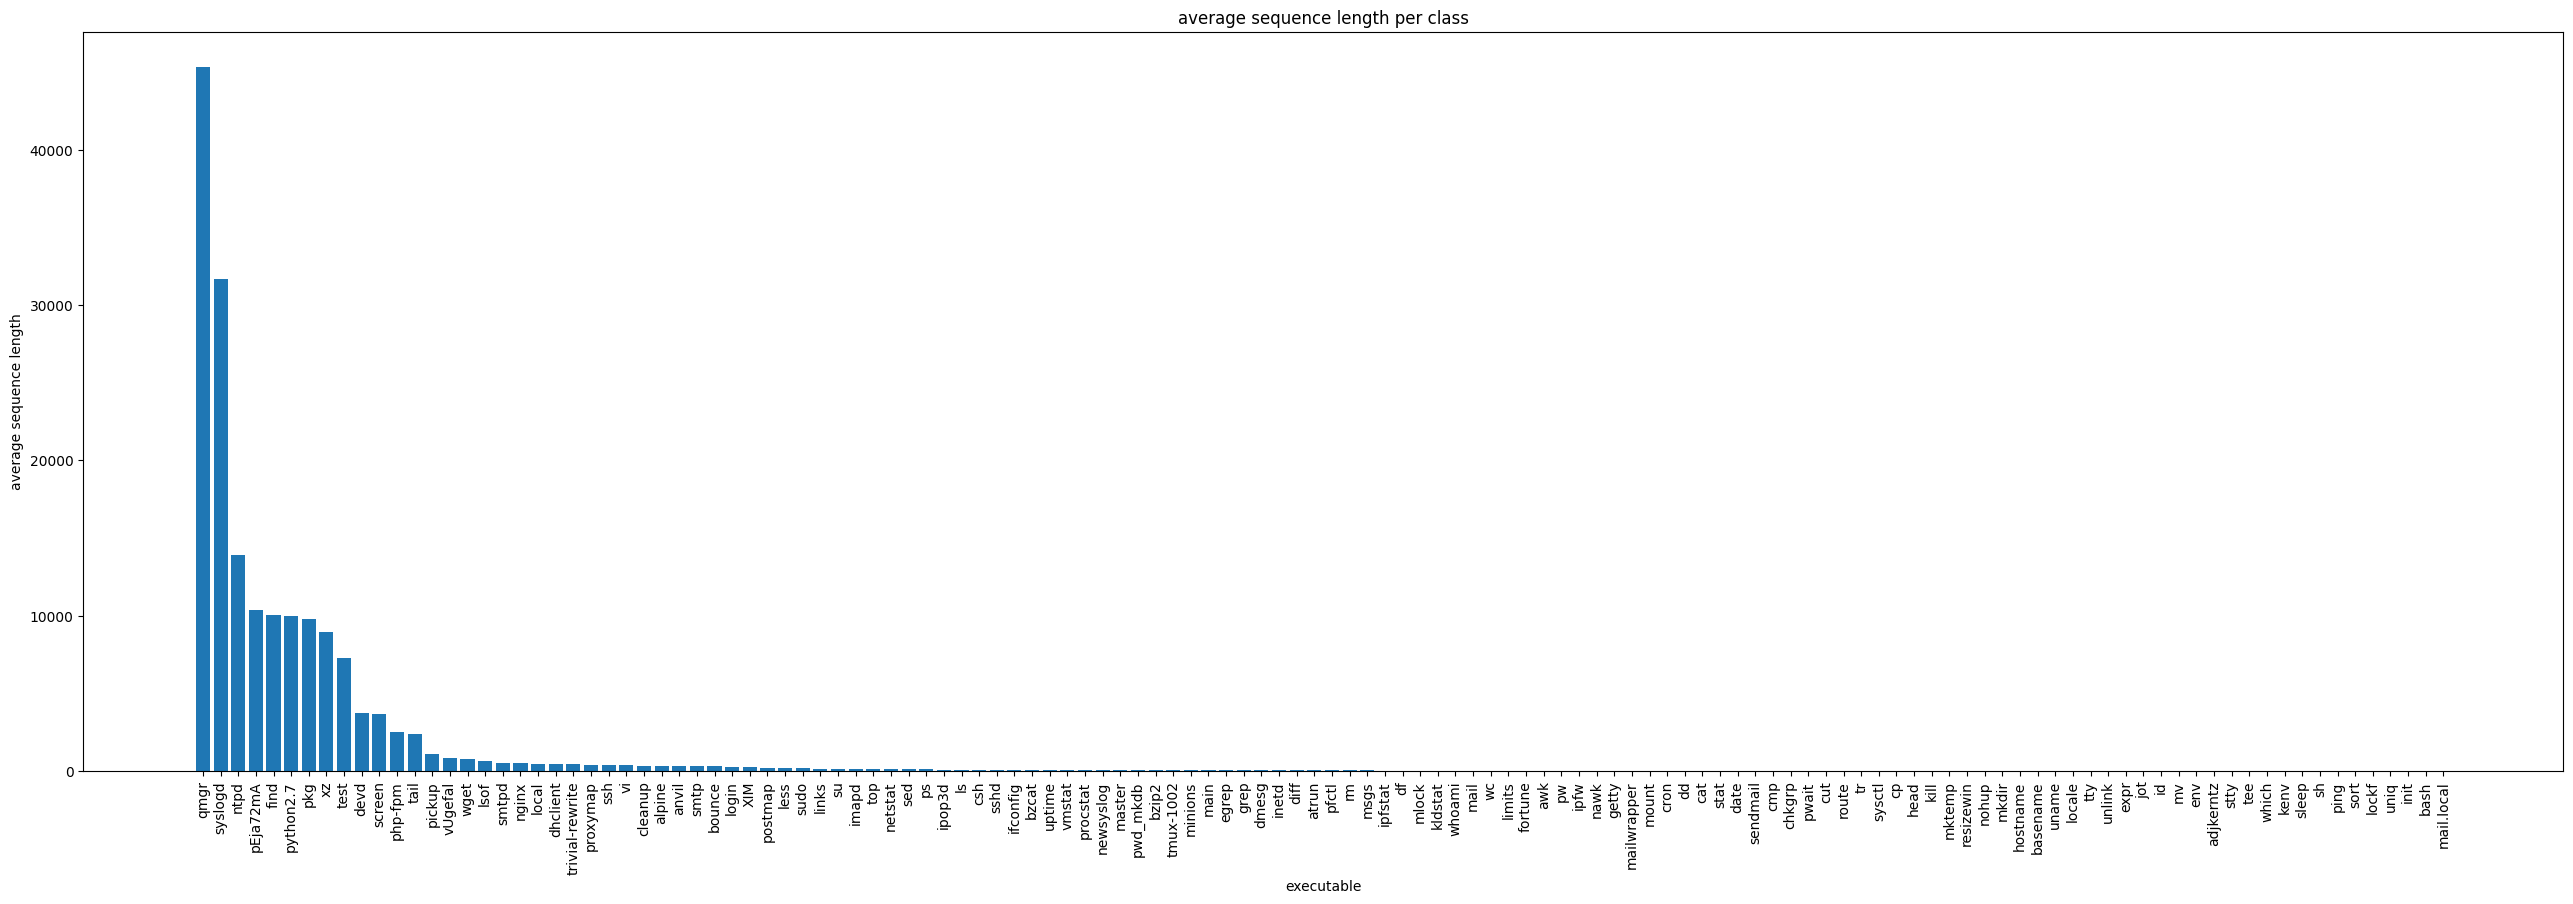

In [38]:
# sort by count
avg_seq_len_per_class.sort(key=lambda x: x[1], reverse=True)

# plot histogram
fig, ax = plt.subplots()

labels = [row[0] for row in avg_seq_len_per_class]
avg_seq_lens = [row[1] for row in avg_seq_len_per_class]

ax.bar(labels, avg_seq_lens)
ax.set_title('average sequence length per class')
ax.set_xlabel('executable')
ax.set_ylabel('average sequence length')

# set x log
# ax.set_yscale('log')

# rotate x labels
plt.xticks(rotation=90)

# resize
fig.set_size_inches(mpl_figsize_xy(5, 2))
plt.show()

note that very many executables have a very low average sequence length

In [39]:
# executables with an average sequence length smaller than 10
print(f'number of classes: {no_classes}')
print(f'number of executables with an average sequence length smaller than 10: {len([row for row in avg_seq_len_per_class if row[1] < 10])}')
print(f'number of executables with an average sequence length smaller than 20: {len([row for row in avg_seq_len_per_class if row[1] < 20])}')
print(f'number of executables with an average sequence length smaller than 100: {len([row for row in avg_seq_len_per_class if row[1] < 100])}')

# get avg sequence length for top 3 classes
for i in range(3):
    print(f'{avg_seq_len_per_class[i][0]}: {avg_seq_len_per_class[i][1]}')
    
# get avg sequence length for bottom 3 classes
for i in range(3):
    print(f'{avg_seq_len_per_class[-i-1][0]}: {avg_seq_len_per_class[-i-1][1]}')
    


number of classes: 128
number of executables with an average sequence length smaller than 10: 3
number of executables with an average sequence length smaller than 20: 9
number of executables with an average sequence length smaller than 100: 86
qmgr: 45314.500000000000
syslogd: 31662.500000000000
ntpd: 13933.0000000000000000
mail.local: 2.0000000000000000
bash: 4.8369691613563422
init: 8.0000000000000000


# attack info  
threatrace has a list of event uuids that are attacks  
load them into a list / set


In [22]:
# open file trustdatastoredb/data/threatrace_cadets_groundtruth.txt

print(f'current working directory: {os.getcwd()}')
try:
    file = open('trustdatastoredb/data/threatrace_cadets_groundtruth.txt', 'r')
except FileNotFoundError:
    try:
        file = open('data/threatrace_cadets_groundtruth.txt', 'r')
    except FileNotFoundError:
        print('file not found')
        raise FileNotFoundError

# read lines
lines = file.readlines()
attack_uuids = set([line.strip() for line in lines])
# close file
file.close()


current working directory: /home/rosendahl/Cloud/hs/bachelor_thesis/trustdatastoredb


check if attack uuids are in the database

In [23]:
# get all table names
query = '''
select table_name
from information_schema.tables
where table_schema = 'public';
'''

cur.execute(query)
table_names = cur.fetchall()

# transform into list
table_names = [row[0] for row in table_names]

# filter out all tables names event*
table_names = [table_name for table_name in table_names if not table_name.startswith('event') or table_name == 'event']

print(table_names)

found = {}
for table_name in table_names:
    found[table_name] = 0

lines_copy = lines.copy()
uuid_not_found = []

for line in lines:
    for table_name in table_names:
        query = f'''
        select count(*)
        from {table_name}
        where uuid = %s;
        '''
        
        cur.execute(query, (line.strip(),))
        
        res = cur.fetchall()[0][0]
        
        if res > 0:
            found[table_name] += 1
            if line in lines_copy:
                lines_copy.remove(line)


print('results:')
for table_name, count in found.items():
    print(f'{table_name}: {count}')

print(f'found {len(lines_copy)} uuids that were not found in any table')

['event', 'fileobject', 'netflowobject', 'node_uuids', 'srcsinkobject', 'subject', 'unnamedpipeobject', 'principal']
results:
event: 1
fileobject: 12810
netflowobject: 25
node_uuids: 12857
srcsinkobject: 0
subject: 16
unnamedpipeobject: 6
principal: 0
found 0 uuids that were not found in any table


In [28]:
# iterate through all sequences and check if they contain any of the attack uuids

# get cols from table event
query = '''
select column_name
from information_schema.columns
where table_name = 'event';
'''
cur.execute(query)
cols = cur.fetchall()

# transform into list
cols = [row[0] for row in cols]
uuid_cols = [col for col in cols if 'uuid' in col]

def row_to_dict(row: tuple) -> dict:
    return {cols[i]: row[i] for i in range(len(cols))}


query = '''
select *
from event
where subject_uuid not in %s
order by subject_uuid, sequence_long;
'''

cur.execute(query, (tuple(subject_blacklist),))

attack_event_uuids = set()
attack_subject_uuids = set()

count = 0
for row in cur:
    row_dict = row_to_dict(row)
    
    # for every col that could contain a uuid
    for col in uuid_cols:
        if row_dict[col] is not None:
            if row_dict[col] in attack_uuids:
                attack_event_uuids.add(row_dict['uuid'])
                attack_subject_uuids.add(row_dict['subject_uuid'])

    count += 1
    if count % 100000 == 0:
        print(f'processed {count} rows, found {len(attack_event_uuids)} attack event uuids')

print(f'found {len(attack_event_uuids)} attack event uuids')


processed 10000 rows, found 1495 attack event uuids
processed 20000 rows, found 3699 attack event uuids
processed 30000 rows, found 5347 attack event uuids
processed 40000 rows, found 5808 attack event uuids
processed 50000 rows, found 7991 attack event uuids
processed 60000 rows, found 9535 attack event uuids
processed 70000 rows, found 11502 attack event uuids
processed 80000 rows, found 12718 attack event uuids
processed 90000 rows, found 12718 attack event uuids
processed 100000 rows, found 12718 attack event uuids
processed 110000 rows, found 13041 attack event uuids
processed 120000 rows, found 15205 attack event uuids
processed 130000 rows, found 16812 attack event uuids
processed 140000 rows, found 18528 attack event uuids
processed 150000 rows, found 20400 attack event uuids
processed 160000 rows, found 22216 attack event uuids
processed 170000 rows, found 23524 attack event uuids
processed 180000 rows, found 24911 attack event uuids
processed 190000 rows, found 26643 attack e

In [29]:
print(f'found {len(attack_event_uuids)} attack event uuids')
print(f'found {len(attack_subject_uuids)} attack subject uuids')

found 2159467 attack event uuids
found 107540 attack subject uuids


In [30]:
# save sets to files
with open('attack_event_uuids.txt', 'w') as file:
    for uuid in attack_event_uuids:
        file.write(f'{uuid}\n')

with open('attack_subject_uuids.txt', 'w') as file:
    for uuid in attack_subject_uuids:
        file.write(f'{uuid}\n')
        
        

In [13]:
# load sets from files
attack_event_uuids = set()
attack_subject_uuids = set()
with open('attack_event_uuids.txt', 'r') as file:
    for line in file:
        attack_event_uuids.add(line.strip())

with open('attack_subject_uuids.txt', 'r') as file:
    for line in file:
        attack_subject_uuids.add(line.strip())

print(f'loaded {len(attack_event_uuids)} attack event uuids')
print(f'loaded {len(attack_subject_uuids)} attack subject uuids')

loaded 2159467 attack event uuids
loaded 107540 attack subject uuids


update the database with the attack information  
a new column 'attack' (bool) was added with the sql command:
```sql
alter table event
    add attack BOOLEAN default FALSE;
```
populate this column

In [14]:
count = 0
for uuid in attack_event_uuids:
    query = f'''
    update event
    set attack = true
    where uuid = \'{uuid}\';
    '''
    
    cur.execute(query)
    count += 1
    if count % 100000 == 0:
        print(f'updated {count} / {no_events}  rows')
        
    
conn.commit()

print(f'updated {count} rows')
    

updated 100000 / 20743978  rows
updated 200000 / 20743978  rows
updated 300000 / 20743978  rows
updated 400000 / 20743978  rows
updated 500000 / 20743978  rows
updated 600000 / 20743978  rows
updated 700000 / 20743978  rows
updated 800000 / 20743978  rows
updated 900000 / 20743978  rows
updated 1000000 / 20743978  rows
updated 1100000 / 20743978  rows
updated 1200000 / 20743978  rows
updated 1300000 / 20743978  rows
updated 1400000 / 20743978  rows
updated 1500000 / 20743978  rows
updated 1600000 / 20743978  rows
updated 1700000 / 20743978  rows
updated 1800000 / 20743978  rows
updated 1900000 / 20743978  rows
updated 2000000 / 20743978  rows
updated 2100000 / 20743978  rows
updated 2159467 rows


# general attack info

In [16]:
# get number of attack events
query = '''
select count(*)
from event
where attack = true;
'''

cur.execute(query)
no_attack_events = cur.fetchall()[0][0]

In [19]:
print(f'number of events: {no_events}')
print(f'number of attack events: {no_attack_events}')
print(f'share of attack events: {no_attack_events*100 / no_events:.5f}%')


number of events: 20743978
number of attack events: 3803715
share of attack events: 18.33648%


find out how many sequences remain after filtering out attack events

In [42]:
query = '''
select count(*)
from (
select s.uuid, count(e.uuid) as seq_len, e.properties_map_exec, max(e.attack::int) as attack
from event e
join subject s
    on e.subject_uuid = s.uuid
where s.uuid not in %s
group by s.uuid, e.properties_map_exec
order by s.uuid, seq_len
) as seq
where attack = 0;
'''

cur.execute(query, (tuple(subject_blacklist),))

no_sequences_no_attack = cur.fetchall()[0][0]

print(f'number of sequences: {no_sequences}')
print(f'number of sequences without attack events: {no_sequences_no_attack}')
print(f'share of sequences without attack events: {no_sequences_no_attack*100 / no_sequences:.5f}%')

number of sequences: 225082
number of sequences without attack events: 7023
share of sequences without attack events: 3.12020%


# end - close resources

In [25]:
# destroy cursor and connection
cur.close()
conn.close()